#BERT 실습

### huggingface Transformer  사용 (https://github.com/huggingface/transformers)

In [1]:
!pip install transformers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 13.6MB/s 
     |████████████████████████████████| 3.8MB 17.7MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fb0c2397083fb41b0f62ef84b108999b6936ee9c84f62ac8170e0e6a335f7341
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### 실습에 필요한 패키지 불러오기

In [0]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

### Naver Movie Data 가져오기

In [3]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [4]:
!ls nsmc -la

total 38652
drwxr-xr-x 5 root root     4096 May 13 06:14 .
drwxr-xr-x 1 root root     4096 May 13 06:14 ..
drwxr-xr-x 2 root root     4096 May 13 06:14 code
drwxr-xr-x 8 root root     4096 May 13 06:14 .git
-rw-r--r-- 1 root root  4893335 May 13 06:14 ratings_test.txt
-rw-r--r-- 1 root root 14628807 May 13 06:14 ratings_train.txt
-rw-r--r-- 1 root root 19515078 May 13 06:14 ratings.txt
drwxr-xr-x 2 root root   479232 May 13 06:14 raw
-rw-r--r-- 1 root root     2596 May 13 06:14 README.md
-rw-r--r-- 1 root root    36746 May 13 06:14 synopses.json


### Excel DataFrame으로 가져오기

In [0]:
train_data = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test_data = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [0]:
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


 id : review id     
 document : review  
 labe : negative -> 0, positive -> 1 

### BERT 토크나이져 

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

In [0]:
train_bert_token_counts = train_data['document'].astype(str).apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Number of reviews')

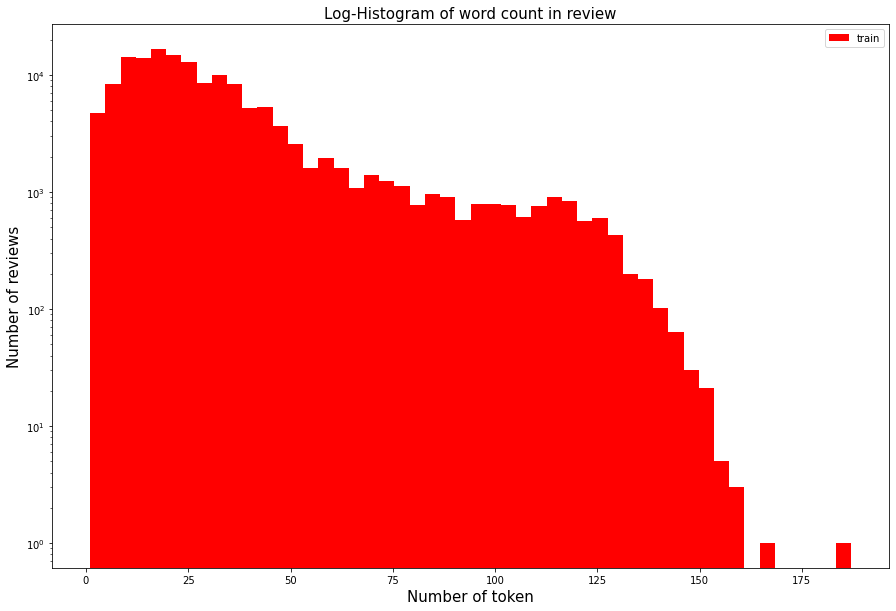

In [0]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of token', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [0]:
print('리뷰 토큰 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('리뷰 토큰 개수 최소 값: {}'.format(np.min(train_bert_token_counts)))
print('리뷰 토큰 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('리뷰 토큰 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('리뷰 토큰 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 토큰 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('리뷰 토큰 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))

리뷰 토큰 개수 최대 값: 187
리뷰 토큰 개수 최소 값: 1
리뷰 토큰 개수 평균 값: 31.76
리뷰 토큰 개수 표준편차: 26.10
리뷰 토큰 개수 중간 값: 24.0
리뷰 토큰 개수 제 1 사분위: 15.0
리뷰 토큰 개수 제 3 사분위: 39.0


### 한글 글꼴 설치

In [0]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

### 워드 클라우드 그리기

(-0.5, 799.5, 599.5, -0.5)

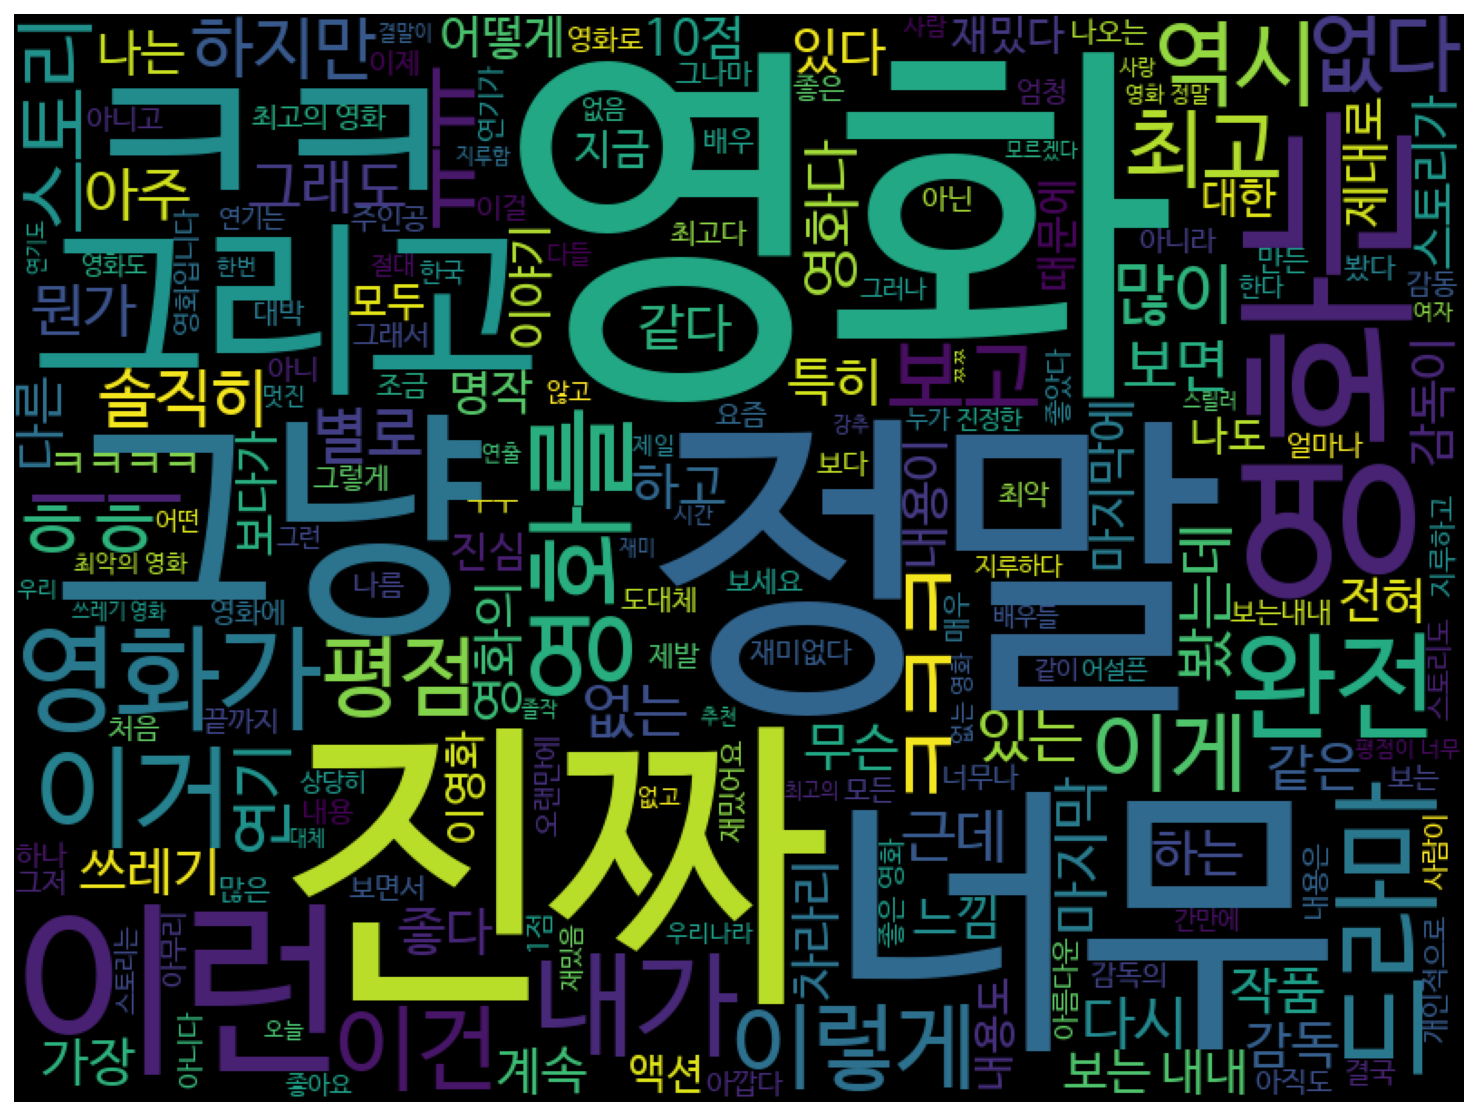

In [0]:
from wordcloud import WordCloud
cloud = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', width=800, height=600).generate(" ".join(train_data['document'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 버트 구조의 입력 데이터 만들기 (tokenization)

In [0]:
sentences = train_data['document']
sentences[:10]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

In [0]:
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]',
 '[CLS] 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. [SEP]',
 '[CLS] 원작의 긴장감을 제대로 살려내지못했다. [SEP]',
 '[CLS] 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 [SEP]',
 '[CLS] 액션이 없는데도 재미 있는 몇안되는 영화 [SEP]',
 '[CLS] 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나? [SEP]']

In [0]:
labels = train_data['label'].values
labels

array([0, 1, 0, ..., 0, 1, 0])

In [0]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [0]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [0]:
print (sentences[0])
print (tokenized_texts[0])

[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']


In [0]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[MASK]', '[CLS]', '[UNK]', '[PAD]', '[SEP]'] 
 [103, 101, 100, 0, 102]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


### 버트 모델 진입

In [0]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased")

In [0]:
#random seed 고정
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 64
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 39 
DATA_IN_PATH = 'nsmc/'
DATA_OUT_PATH = "nsmc/"

### 위에 인덱스 값 확인 필요

In [0]:
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [0]:
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent) 
    return sent_clean

In [0]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in zip(train_data["document"], train_data["label"]):
    try:
        token_sent = tokenizer.encode(clean_text(train_sent))
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(train_sent))
        continue
        
    train_data_sents.append(token_sent) #append는 빼 놓고 한다.
    train_data_labels.append(train_label)

train_data_sent_pads = pad_sequences(train_data_sents, maxlen=MAX_LEN, padding='post')
train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블

print("num sents, labels {}, {}".format(len(train_data_sent_pads), len(train_data_labels)))

Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
num sents, labels 149995, 149995


In [0]:
print(train_data_sent_pads[0])

[   101   9519   9074 119005   9708 119235   9715 119230  16439  77884
  48549   9284  22333  12692    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0]


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) # 인자 확인
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # 해당 값 확인
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [0]:
model_name = "tf2_bert_naver_movie"

In [0]:
!nvidia-smi

Tue May 12 23:50:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |   2331MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=3)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_sent_pads, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

nsmc/tf2_bert_naver_movie -- Folder already exists 

Epoch 1/20
1875/1875 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7206
Epoch 00001: val_accuracy improved from -inf to 0.80469, saving model to nsmc/tf2_bert_naver_movie/weights.h5
1875/1875 [==============================] - 1033s 551ms/step - loss: 0.5303 - accuracy: 0.7206 - val_loss: 0.4279 - val_accuracy: 0.8047
Epoch 2/20
1875/1875 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.7975
Epoch 00002: val_accuracy did not improve from 0.80469
1875/1875 [==============================] - 1029s 549ms/step - loss: 0.4251 - accuracy: 0.7975 - val_loss: 0.4057 - val_accuracy: 0.7969
Epoch 3/20
1875/1875 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8261
Epoch 00003: val_accuracy did not improve from 0.80469
1875/1875 [==============================] - 1029s 549ms/step - loss: 0.3755 - accuracy: 0.8261 - val_loss: 0.4285 - val_accuracy: 0.7969
Epoch 4/20
1875/187

### 결과 그래프 보기

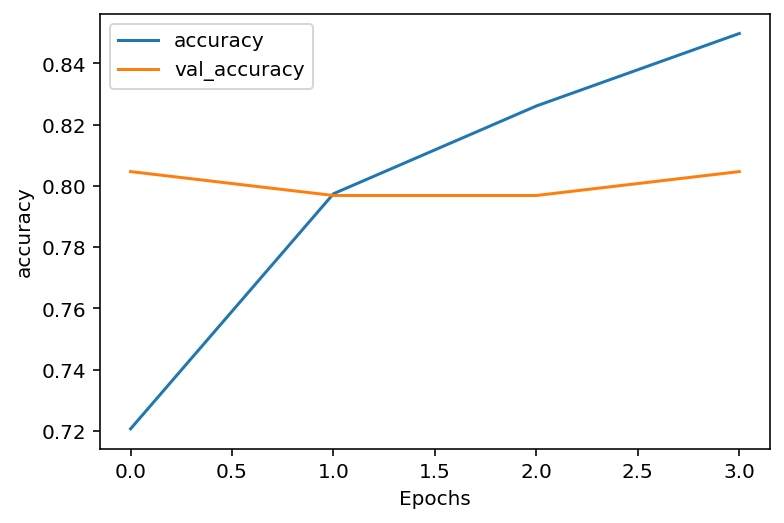

In [0]:
plot_graphs(history, 'accuracy')

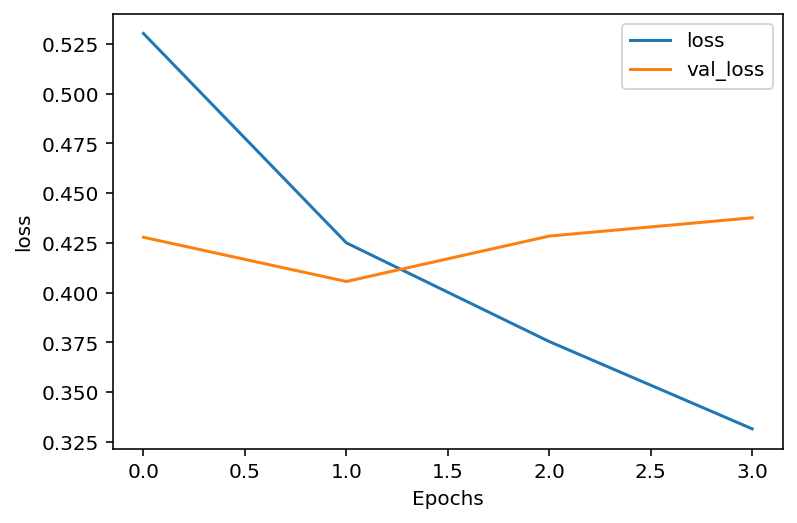

In [0]:
plot_graphs(history, 'loss')

In [0]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in zip(test_data["document"], test_data["label"]):
    try:
        token_sent = tokenizer.encode(clean_text(test_sent))
        test_data_sents.append(token_sent)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_data_sent_pad = pad_sequences(test_data_sents, maxlen=MAX_LEN, padding='post') # convert into numpy
test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_data_sent_pad), len(test_data_labels)))

expected string or bytes-like object
nan
expected string or bytes-like object
nan
expected string or bytes-like object
nan
num sents, labels 49997, 49997


In [0]:
results = model.evaluate(test_data_sent_pad, test_data_labels)
print("test loss, test acc: ", results)

1563/1563 [==============================] - 144s 92ms/step - loss: 0.4332 - accuracy: 0.8105
test loss, test acc:  [0.4331945776939392, 0.8104886412620544]


In [0]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 May 12 23:26 .
drwxr-xr-x 1 root root 4096 May 12 23:24 ..
drwxr-xr-x 1 root root 4096 May  8 16:16 .config
drwxr-xr-x 6 root root 4096 May 12 23:29 nsmc
drwxr-xr-x 1 root root 4096 May  4 16:26 sample_data


In [0]:
!cd nsmc

In [0]:
!ls nsmc -la

total 38660
drwxr-xr-x 6 root root     4096 May 12 23:29 .
drwxr-xr-x 1 root root     4096 May 12 23:26 ..
drwxr-xr-x 2 root root     4096 May 12 23:26 code
drwxr-xr-x 8 root root     4096 May 12 23:26 .git
-rw-r--r-- 1 root root  4893335 May 12 23:26 ratings_test.txt
-rw-r--r-- 1 root root 14628807 May 12 23:26 ratings_train.txt
-rw-r--r-- 1 root root 19515078 May 12 23:26 ratings.txt
drwxr-xr-x 2 root root   479232 May 12 23:26 raw
-rw-r--r-- 1 root root     2596 May 12 23:26 README.md
-rw-r--r-- 1 root root    36746 May 12 23:26 synopses.json
drwxr-xr-x 2 root root     4096 May 13 00:08 tf2_bert_naver_movie
